# Dit jupyter notebook is een voorbeeld van hoe je Ozon rates kunt berekenen en visualiseren op een simpele manier in Python. 

Ik gebruik scipy voor de differentiaalvergelijking (ODE) oplossen. Je zou ook al meteen een specifiek chemische python module kunnen gebruiken die deze functionaliteit al heeft, maar dan is het helemaal geen uitdaging meer.. Bovendien is dit wat inzichtelijker denk ik en breek toepasbaar voor andere dynamiek met gekoppelde differentiaalvergelijkingen (bv gekoppelde slingers e.d.)

Eerst de gebruikte pythonmodules laden. 

In [ ]:
import sympy as sym
import numpy as np
from scipy.integrate import odeint
sym.init_printing()
import matplotlib.pyplot as plt
%matplotlib inline

# Eerst zonder symbolische functie

Via de sympy module kun je symbolische wiskunde gebruiken ipv numeriek. Integreren en differentieren e.d. gaat dan symbolisch ipv met array's met nummers. Dit kan in vele gevallen veel efficienter zijn en ook meer vergelijkbaar met hoe je het normaal zelf zou doen.

Eerst doe ik de numerieke methode

In [228]:
# Chapman cycle
def rate_eq(y, t, M, k1,k2,k3,k4):
    O = y[0]
    O2 = y[1]
    O3 = y[2]
    dO = 2 * k1 * O2 + k3 * O3 - k2 * O * O2 * M - k4*O*O3
    dO2 = k3 * O3 + 2 * k4 * O*O3 - k1 * O2 - k2 * O * O2 * M
    dO3 = k2 * O * O2 * M - k3*O3 - k4 * O * O3
    return [dO,dO2,dO3]

Deze onderstaande constante waarden veranderen per hoogte. Ik pak nu maar 1 hoogte, maar het is triviaal om dit uit te breiden voor vergelijkingen per hoogte


In [230]:
# M voor interactie met omgeving
M_val = 9e17

# K voor de rate constanten k_vals [ k1, k2, k3, etc..]
k_vals = [3e-12,1.22e-33,5.5e-4,6.86e-16]

# y0 zijn de initiele waarden van de atmosfeer op tijd 0. We beginnen dus met alleen O2 in onstaande array
# y0 = [O_0, O2_0, O3_0]
y0 = [0, 0.21*M_val, 0.0]


Final State concentrations:
O: 4.68E+07
O_2: 1.89E+17
O_3: 1.77E+13


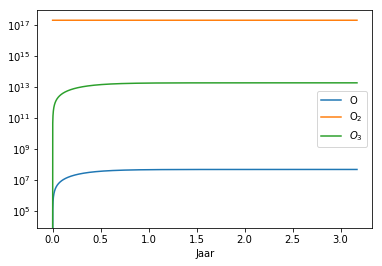

In [231]:
# Tijd om over te berekenen, 1e8 seconden, ongeveer 3 jaar
tout = np.linspace(0, 1e8,10001)

# Hier is het oplossen van de ODE
result = odeint(rate_eq, y0, tout, args=(M_val,*k_vals))

# Plot het resultaat
ax= plt.plot(tout/(365*24*3600), result)
_ = plt.legend(['O', 'O$_2$', '$O_3$'])
plt.semilogy()
plt.xlabel("Jaar")

# Print de laatste array waarde, we gaan er hier vanuit dat dit de constante waarde heeft bereikt
print("Final State concentrations:\nO: %.2E\nO_2: %.2E\nO_3: %.2E" % (result[-1][0],result[-1][1],result[-1][2]))

# Met symbolische functies in sympy ipv numeriek

In [232]:
y, M, k = sym.symbols('O O_2 O_3'), sym.symbols('M'), sym.symbols('k_1 k_2 k_3 k_4')

In [233]:
t = sym.symbols('t')  
f = sym.lambdify((y, t,M) + k, rate_eq(y,None,M,*k),dummify=False)
f(y,t,M,*k)

Formule is in vorm van de chapmal cycle rate equation maar nu dus met symbolen 

Final State concentrations:
O: 4.68E+07
O_2: 1.89E+17
O_3: 1.77E+13


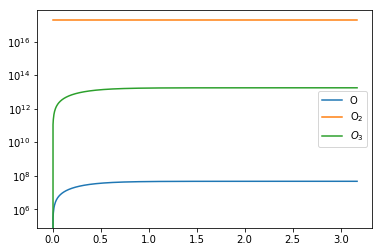

In [235]:
# Doe weer hetzelfde als hierboven 
tout = np.linspace(0, 1e8,1000)

# Nu geven we symbolische functie f mee 
result_sym = odeint(f, y0, tout, args=(M_val,*k_vals))
ax= plt.plot(tout/(365*24*3600), result_sym)
_ = plt.legend(['O', 'O$_2$', '$O_3$'])
plt.semilogy()
print("Final State concentrations:\nO: %.2E\nO_2: %.2E\nO_3: %.2E" % (result_sym[-1][0],result_sym[-1][1],result_sym[-1][2]))

Resultaat is hetzelfde

# Met CFC's die de boel vernagelen

De zon kun je ook stuk maken met CFC's. Je kunt wat Frenon 12 in de atmosfeer gooien en kijken wat er gebeurt. Idee gejat van Gejat van: http://www.columbia.edu/itc/chemistry/chem-c2407/hw/ozone_kinetics.pdf zie daar ook voor meer info over hoe Frenon_12 in Cl en ClO uit elkaar valt

In [236]:
# 3 exgtra rate constanten zijn erbij gekomen (k5,k6,k7) 
def rate_eq_with_CFC(y, t, M, k1,k2,k3,k4,k5,k6,k7):
    O = y[0]
    O2 = y[1]
    O3 = y[2]
    ClO = y[3]
    Cl = y[4]
    Cf2Cl2 = y[5]
    dO = 2 * k1 * O2 + k3 * O3 - k2 * O * O2 * M - k4*O*O3 - k7*ClO*O
    # Heb dO2 niet veranderd, is toch vrijwel constant
    dO2 = k3 * O3 + 2 * k4 * O*O3 - k1 * O2 - k2 * O * O2 * M
    dO3 = k2 * O * O2 * M - k3*O3 - k4 * O * O3 - k6*Cl * O3
    dCf2Cl2 = -k5*Cf2Cl2
    dCl = k5*Cf2Cl2-k6*Cl*O3+k7*ClO*O
    dClO = k6*Cl*O3-k7*ClO*O
    return [dO,dO2,dO3,dClO,dCl,dCf2Cl2]

In [237]:
# Waarden voor nieuwe constanten komen uit de bovenstaande pdf, is realistisch voor een bepaalde hoogte
M_val = 9e17
k_vals = [3e-12,1.22e-33,5.5e-4,6.86e-16,1e-7,2.1e-11,3.8e-11]
y, M, k = sym.symbols('O O_2 O_3 ClO Cl Cf_2Cl_2'), sym.symbols('M'), sym.symbols('k_1 k_2 k_3 k_4 k_5 k_6 k_7')
t = sym.symbols('t')  
f = sym.lambdify((y, t,M) + k, rate_eq_with_CFC(y,None,M,*k),dummify=False)
f(y,t,M,*k)

Bereken eerst met GEEN Frenon_12

Final State concentrations:
O: 4.68E+07
O_2: 1.89E+17
O_3: 1.77E+13
ClO: 0.00E+00
Cl: 0.00E+00
Cf_2Cl_2:0.00E+00


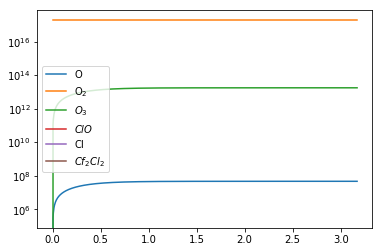

In [44]:

tout = np.linspace(0, 1e8,1000)
Freon_12 = 0
y0 = [0, 0.21*M_val, 0.0*M_val, 0, 0, Freon_12]
result_sym = odeint(f, y0, tout, args=(M_val,*k_vals))
ax= plt.plot(tout/(365*24*3600), result_sym)
_ = plt.legend(['O', 'O$_2$', '$O_3$','$ClO$','Cl','$Cf_2Cl_2$'])
plt.semilogy()
print("Final State concentrations:\nO: %.2E\nO_2: %.2E\nO_3: %.2E\nClO: %.2E\nCl: %.2E\nCf_2Cl_2:%.2E" % (result_sym[-1][0],result_sym[-1][1],result_sym[-1][2],result_sym[-1][3],result_sym[-1][4],result_sym[-1][5]))

Resultaten zijn identiek, zoals verwacht, alles klopt dus nog (sanity check))

Als we de resultaten van de vorige run als input nemen, maar we gooien er wat Frenon 12 tegenaan 

In [239]:
y0 = result_sym[-1]
Freon_12 = 1e10
y0[-1] = Freon_12
y0

array([4.68046629e+07, 1.88973515e+17, 1.00000000e+10])

Final State concentrations:
O: 1.56E+06
O_2: 1.89E+17
O_3: 5.88E+11
ClO: 9.57E+09
Cl: 4.60E+04
Cf_2Cl_2:4.27E+08


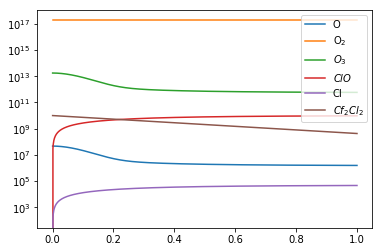

In [56]:
tout = np.linspace(0, 365*24*3600*1,1000)
result_cfc = odeint(f, y0, tout, args=(M_val,*k_vals))
ax= plt.plot(tout/(365*24*3600), result_cfc)
_ = plt.legend(['O', 'O$_2$', '$O_3$','$ClO$','Cl','$Cf_2Cl_2$'])
plt.semilogy()
print("Final State concentrations:\nO: %.2E\nO_2: %.2E\nO_3: %.2E\nClO: %.2E\nCl: %.2E\nCf_2Cl_2:%.2E" % (result_cfc[-1][0],result_cfc[-1][1],result_cfc[-1][2],result_cfc[-1][3],result_cfc[-1][4],result_cfc[-1][5]))

 Nu is de Ozon voor altijd de lul, er moet nog een sink bij voor Cl. Volgens wikipedia kan 1 Cl ongevee 100000 interacties met Ozon aangaan voordat het uit de stratosfeer verdwijnt. Ik gebruik een random rate voor nu, maar dit kan je meenemen als je het serieus wil doen:

In [222]:
#Cl removal rate:
k8 = 1/(36)
print(k8)

0.027777777777777776


In [240]:
def rate_eq_with_CFC_CfSink(y, t, M, k1,k2,k3,k4,k5,k6,k7,k8):
    O = y[0]
    O2 = y[1]
    O3 = y[2]
    ClO = y[3]
    Cl = y[4]
    Cf2Cl2 = y[5]
    dO = 2 * k1 * O2 + k3 * O3 - k2 * O * O2 * M - k4*O*O3 - k7*ClO*O
    # Heb dO2 niet veranderd, is toch vrijwel constant
    dO2 = k3 * O3 + 2 * k4 * O*O3 - k1 * O2 - k2 * O * O2 * M
    dO3 = k2 * O * O2 * M - k3*O3 - k4 * O * O3 - k6*Cl * O3
    dCf2Cl2 = -k5*Cf2Cl2
    dCl = k5*Cf2Cl2-k6*Cl*O3+k7*ClO*O-k8*Cl
    dClO = k6*Cl*O3-k7*ClO*O
    return [dO,dO2,dO3,dClO,dCl,dCf2Cl2]

In [241]:
M_val = 9e17
k_vals = [3e-12,1.22e-33,5.5e-4,6.86e-16,1e-7,2.1e-11,3.8e-11,k8]
y, M, k = sym.symbols('O O_2 O_3 ClO Cl Cf_2Cl_2'), sym.symbols('M'), sym.symbols('k_1 k_2 k_3 k_4 k_5 k_6 k_7 k_8')
t = sym.symbols('t')  
f = sym.lambdify((y, t,M) + k, rate_eq_with_CFC_CfSink(y,None,M,*k),dummify=False)
f(y,t,M,*k)

In [242]:
tout = np.linspace(0, 1e8,1000)
Freon_12 = 0
y0 = [0, 0.21*M_val, 0.0*M_val, 0, 0, Freon_12]
resultWithoutCFC = odeint(f, y0, tout, args=(M_val,*k_vals))
# print("Final State concentrations:\nO: %.2E\nO_2: %.2E\nO_3: %.2E\nClO: %.2E\nCl: %.2E\nCf_2Cl_2:%.2E" % (resultWithoutCFC[-1][0],resultWithoutCFC[-1][1],resultWithoutCFC[-1][2],resultWithoutCFC[-1][3],resultWithoutCFC[-1][4],resultWithoutCFC[-1][5]))
# add Frenon 12:
y0 = resultWithoutCFC[-1]
Freon_12 = 1e10
y0[-1] = Freon_12
resultWithCFC = odeint(f, y0, tout, args=(M_val,*k_vals))

Final State concentrations:
O: 4.65E+07
O_2: 1.89E+17
O_3: 1.75E+13
ClO: 1.32E+06
Cl: 6.31E+00
Cf_2Cl_2:4.54E+05


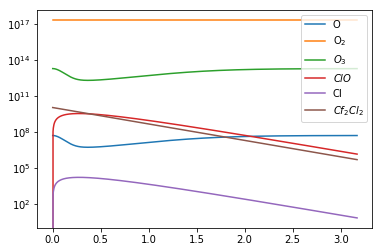

In [243]:
ax= plt.plot(tout/(365*24*3600), resultWithCFC)
_ = plt.legend(['O', 'O$_2$', '$O_3$','$ClO$','Cl','$Cf_2Cl_2$'])
plt.semilogy()
print("Final State concentrations:\nO: %.2E\nO_2: %.2E\nO_3: %.2E\nClO: %.2E\nCl: %.2E\nCf_2Cl_2:%.2E" % (resultWithCFC[-1][0],resultWithCFC[-1][1],resultWithCFC[-1][2],resultWithCFC[-1][3],resultWithCFC[-1][4],resultWithCFC[-1][5]))

Een dip in Ozon maar herstelt zich meer naarmate Cl verdwijnt uit de stratosfeer. Gebruikte hoeveelheid Frenon12 en Cl sink rate zijn volledig willekeurig en waarschijnlijk volstrekte onzin btw maar het idee klopt wel